In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipynb

import sys 
import os
sys.path.append(os.getcwd())
from ipynb.fs.full.preprocessing_pk import *
from ipynb.fs.full.models_pk import *
from ipynb.fs.full.evaluation_pk import *

# Expand displayed data rows and columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

sns.set_style("darkgrid")
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_input=pd.read_csv('model_input.csv')

In [3]:
active_positive=((df_input['is_activated']==1)&(df_input['marketing_campaign_response']==1))
nontactive_negative=((df_input['is_activated']==0)&(df_input['marketing_campaign_response']==0))
baseline_accuracy=len(df_input[active_positive|nontactive_negative])/len(df_input)
print(f'Baseline accuracy of prediction when only using is_actived {baseline_accuracy}')

Baseline accuracy of prediction when only using is_actived 0.92525


In [4]:
def base_accuracy(df, criterion, target):
    active_positive=((df[criterion]==1)&(df_input[target]==1))
    nontactive_negative=((df[criterion]==0)&(df[target]==0))
    baseline_accuracy=len(df[active_positive|nontactive_negative])/len(df)
    return baseline_accuracy

## Preprocessing

In [5]:
# Overall conversion
X, y=data_pipeline(df_input, 'marketing_campaign_response')
X=X.drop(columns=['account_id'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   third_party_integrations        20000 non-null  int64
 1   enterprise_account_legacy       20000 non-null  bool 
 2   is_activated                    20000 non-null  bool 
 3   has_cloud_storage               20000 non-null  bool 
 4   has_cloud_storage_only          20000 non-null  bool 
 5   num_services_cap                20000 non-null  int64
 6   clusters_score                  20000 non-null  int64
 7   tier_level_PREMIUM              20000 non-null  uint8
 8   third_party_integration_flag_2  20000 non-null  uint8
 9   recency_months_cluster_2        20000 non-null  uint8
 10  num_services_cap_cluster_0      20000 non-null  uint8
 11  num_services_cap_cluster_2      20000 non-null  uint8
 12  segment_high                    20000 non-null  uint8
 13  s

In [6]:
## Investigate the correlations between dependent and independent variables
pd.concat([X,y], axis=1).corr(method='pearson').loc['marketing_campaign_response'].sort_values(ascending=False)

marketing_campaign_response       1.000000
is_activated                      0.848571
num_services_cap                  0.698467
clusters_score                    0.659359
segment_high                      0.538014
num_services_cap_cluster_2        0.484303
recency_months_cluster_2          0.454810
third_party_integration_flag_2    0.386497
third_party_integrations          0.233669
enterprise_account_legacy         0.040954
has_cloud_storage                -0.468048
segment_low                      -0.574485
tier_level_PREMIUM               -0.583845
num_services_cap_cluster_0       -0.710331
has_cloud_storage_only           -0.720397
Name: marketing_campaign_response, dtype: float64

In [7]:
### Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=14)

In [8]:
base_accuracy(pd.concat([X_train, y_train], axis=1), 'is_activated', 'marketing_campaign_response')

0.9245

In [9]:
## initiate the table for model comparisons over training and testing
models_train=pd.DataFrame(columns=['model', 'best_training_accuracy'])
models_test=pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall'])

## Modeling Training

### 1. Logistic Regression

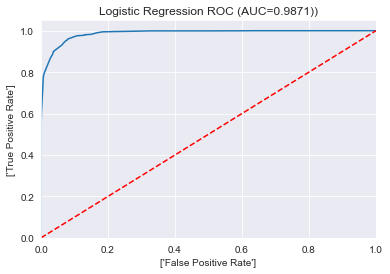

In [10]:
#logistic regression modeling function: logist(x_train, y_train, predictors' names ,number of cv)
columns=['is_activated','has_cloud_storage_only','clusters_score',
         'tier_level_PREMIUM','third_party_integration_flag_2' ]

logist_model, logist_perf=logist(X_train, y_train, columns,5)
models_train=pd.concat([models_train, logist_perf], ignore_index=True)

logist_model.fit(X_train[columns], y_train)
y_pred=logist_model.predict(X_test[columns])
probs=logist_model.predict_proba(X_test[columns])
y1_prob=probs[:, 1]

logist_eval=pd.DataFrame(eval_metrics('logistic', y_test, y_pred), index=[0])
models_test=pd.concat([models_test, logist_eval], ignore_index=True)
roc_auc_plot('Logistic Regression', y_test, y1_prob)

### 2. Decision Tree

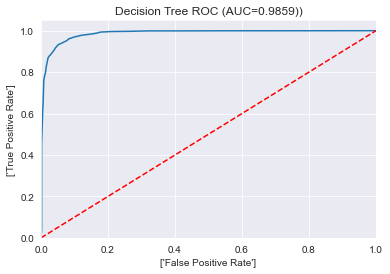

In [11]:
#decision tree modeling function: decision_tree(x_train, y_train, predictors' names ,number of cv)
dtree_model, dtree_perf=decision_tree(X_train, y_train, 'all',5)
models_train=pd.concat([models_train, dtree_perf], ignore_index=True)

dtree_model.fit(X_train, y_train)
y_pred=dtree_model.predict(X_test)
probs=dtree_model.predict_proba(X_test)
y1_prob=probs[:, 1]

dtree_eval=pd.DataFrame(eval_metrics('decision tree', y_test, y_pred), index=[0])
models_test=pd.concat([models_test, dtree_eval], ignore_index=True)
roc_auc_plot('Decision Tree', y_test, y1_prob)

### 3. Random Forest

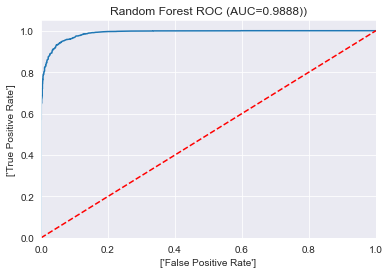

In [12]:
#random forest modeling function: random_forest(x_train, y_train, predictors' names ,number of cv)
rf_model, rf_perf=random_forest(X_train, y_train, 'all', 5)
models_train=pd.concat([models_train, rf_perf], ignore_index=True)

rf_model.fit(X_train, y_train)
y_pred=rf_model.predict(X_test)
probs=rf_model.predict_proba(X_test)
y1_prob=probs[:, 1]

rf_eval=pd.DataFrame(eval_metrics('random forest', y_test, y_pred), index=[0])
models_test=pd.concat([models_test, rf_eval], ignore_index=True)
roc_auc_plot('Random Forest', y_test, y1_prob)

### 4. SVM

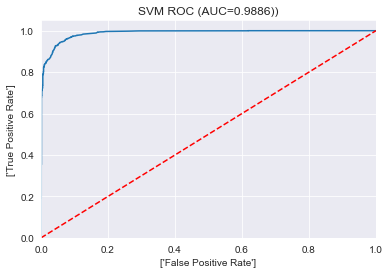

In [13]:
#svm modeling function: svm(x_train, y_train, predictors' names ,number of cv)
svm_model, svm_perf=svm(X_train, y_train, 'all',5)
models_train=pd.concat([models_train, svm_perf], ignore_index=True)

svm_model.fit(X_train, y_train)
y_pred=svm_model.predict(X_test)
probs=svm_model.predict_proba(X_test)
y1_prob=probs[:, 1]

svm_eval=pd.DataFrame(eval_metrics('svm', y_test, y_pred),index=[0])
models_test=pd.concat([models_test, svm_eval], ignore_index=True)
roc_auc_plot('SVM', y_test, y1_prob)

## Modeling Comparison

In [23]:
## Training performance
basetrain_accuracy=base_accuracy(pd.concat([X_train, y_train], axis=1), 'is_activated', 'marketing_campaign_response')
models_train['gt_than_baseline_0.92']=models_train['best_training_accuracy']>=basetrain_accuracy

models_train

,model,best_training_accuracy,gt_than_baseline_0.92
0,logistic,0.9361,True
1,decision tree,0.9397,True
2,random forest,0.9425,True
3,svm,0.9426,True


In [26]:
## Testing performance
basetest_accuracy=base_accuracy(pd.concat([X_test, y_test], axis=1), 'is_activated', 'marketing_campaign_response')
models_test['gt_than_baseline_0.928']=models_test['accuracy']>=basetest_accuracy

models_test

,model,accuracy,precision,recall,gt_than_baseline_0.928
0,logistic,0.9425,0.9403,0.9594,True
1,decision tree,0.9398,0.9579,0.9347,True
2,random forest,0.9438,0.9517,0.9488,True
3,svm,0.9432,0.9533,0.9462,True


## Feature Importance

In [16]:
feature_importance(logist_model, 'linear', columns).sort_values(by='tree_importance', key=abs, ascending=False)

,variables,tree_importance
0,is_activated,3.945354
3,tier_level_PREMIUM,-2.993601
4,third_party_integration_flag_2,2.345777
2,clusters_score,1.195023
1,has_cloud_storage_only,-0.318622


In [17]:
feature_importance(dtree_model, 'non-linear', X_train.columns).reset_index(drop=True)

,variables,tree_importance
0,is_activated,0.863421
1,clusters_score,0.063261
2,third_party_integration_flag_2,0.033886
3,tier_level_PREMIUM,0.013930
4,third_party_integrations,0.010353
5,recency_months_cluster_2,0.009349
6,num_services_cap,0.003104
7,has_cloud_storage_only,0.001057
8,segment_high,0.000973
9,has_cloud_storage,0.000271


In [18]:
feature_importance(rf_model, 'non-linear', X_train.columns).reset_index(drop=True)

,variables,tree_importance
0,is_activated,0.244708
1,num_services_cap,0.227262
2,num_services_cap_cluster_0,0.118300
3,has_cloud_storage_only,0.112292
4,clusters_score,0.075404
5,tier_level_PREMIUM,0.075122
6,segment_low,0.048611
7,third_party_integration_flag_2,0.024743
8,segment_high,0.022623
9,recency_months_cluster_2,0.022499
